In [38]:
import pandas as pd
import numpy as np

from functools import reduce

from sqlalchemy import create_engine

from datetime import date

import matplotlib.pyplot as plt
import seaborn as sns

# Loading raw data

In [39]:
offers = pd.read_json('data/portfolio.json', orient='records', lines=True)
users = pd.read_json('data/profile.json', orient='records', lines=True)
interactions = pd.read_json('data/transcript.json', orient='records', lines=True)

In [40]:
offers

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [41]:
for cn in offers.columns:
    if cn not in ['id', 'channels']:
        display( offers.groupby(cn).agg( count=('id', 'count') ) )

,count
reward,
0,2
2,2
3,1
5,3
10,2


,count
difficulty,
0,2
5,2
7,1
10,4
20,1


,count
duration,
3,1
4,1
5,2
7,4
10,2


,count
offer_type,
bogo,4
discount,4
informational,2


# Users

In [42]:
users

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [43]:
for cn in users.columns:
    if cn not in ['id']:
        agg_count = users.groupby(cn, dropna=False).agg( count=('id', 'count') )
        agg_count['percent'] = round( agg_count['count'] / agg_count['count'].sum() * 100, 2 )

        display( agg_count.sort_values('count', ascending=False) )

,count,percent
gender,,
M,8484,49.91
F,6129,36.05
NaN,2175,12.79
O,212,1.25


,count,percent
age,,
118,2175,12.79
58,408,2.40
53,372,2.19
51,363,2.14
59,359,2.11
...,...,...
100,12,0.07
96,8,0.05
98,5,0.03


,count,percent
became_member_on,,
20171207,43,0.25
20170819,42,0.25
20171007,40,0.24
20171113,39,0.23
20170928,38,0.22
...,...,...
20130801,1,0.01
20130915,1,0.01
20130806,1,0.01


,count,percent
income,,
NaN,2175,12.79
73000.0,314,1.85
72000.0,297,1.75
71000.0,294,1.73
57000.0,288,1.69
...,...,...
116000.0,46,0.27
112000.0,45,0.26
107000.0,45,0.26


# Loading data

In [44]:
conn = create_engine('sqlite:///data/starbucks_data.db')

# Loading the offers data
offers = pd.read_sql('SELECT * FROM offers', conn)

# Loading the user data
users = pd.read_sql('SELECT * FROM users', conn)
# Adding back categorical columns for the users that were lost by saving to the database
users['user_gender'] = users['user_gender'].fillna('N/A')
user_gender_cats = [ 'N/A', 'O', 'F', 'M' ]
users['user_gender'] = pd.Categorical(users['user_gender'], categories=user_gender_cats, ordered=True)

users['user_age_group'] = users['user_age_group'].fillna('N/A')
user_age_cats = ['N/A', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']
users['user_age_group'] = pd.Categorical(users['user_age_group'], categories=user_age_cats, ordered=True)

user_income_cats = ['N/A', '<50k', '50k-75k', '75k-100k', '>100k']
users['user_income_group'] = pd.Categorical(users['user_income_group'], categories=user_income_cats, ordered=False)

# Loading the interactions data
interactions = pd.read_sql('SELECT * FROM interactions', conn)

# Offers Table

In [45]:
display( offers )

,offer_id,offer_notification_channel,offer_type,offer_spend_minimum,offer_reward,offer_duration,offer_reward_vs_spend
0,ae264e3637204a6fb9bb56bc8210ddfd,email,bogo,10,10,168,1.00
1,ae264e3637204a6fb9bb56bc8210ddfd,mobile,bogo,10,10,168,1.00
2,ae264e3637204a6fb9bb56bc8210ddfd,social,bogo,10,10,168,1.00
3,4d5c57ea9a6940dd891ad53e9dbe8da0,web,bogo,10,10,120,1.00
4,4d5c57ea9a6940dd891ad53e9dbe8da0,email,bogo,10,10,120,1.00
5,4d5c57ea9a6940dd891ad53e9dbe8da0,mobile,bogo,10,10,120,1.00
6,4d5c57ea9a6940dd891ad53e9dbe8da0,social,bogo,10,10,120,1.00
7,3f207df678b143eea3cee63160fa8bed,web,informational,0,0,96,0.00
8,3f207df678b143eea3cee63160fa8bed,email,informational,0,0,96,0.00
9,3f207df678b143eea3cee63160fa8bed,mobile,informational,0,0,96,0.00


In [46]:
display( offers.groupby(['offer_id', 'offer_type']).count() )

,,offer_notification_channel,offer_spend_minimum,offer_reward,offer_duration,offer_reward_vs_spend
offer_id,offer_type,,,,,
0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,2,2,2,2,2
2298d6c36e964ae4a3e7e9706d1fb8c2,discount,4,4,4,4,4
2906b810c7d4411798c6938adc9daaa5,discount,3,3,3,3,3
3f207df678b143eea3cee63160fa8bed,informational,3,3,3,3,3
4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,4,4,4,4,4
5a8bc65990b245e5a138643cd4eb9837,informational,3,3,3,3,3
9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,3,3,3,3,3
ae264e3637204a6fb9bb56bc8210ddfd,bogo,3,3,3,3,3
f19421c1d4aa40978ebb69ca19b0e20d,bogo,4,4,4,4,4


# User Table

In [47]:
display(users.head())

,user_id,user_gender,user_age,user_member_since,user_income,user_tenure,user_age_group,user_income_group
0,68be06ca386d4c31939f3a4f0e3dd783,N/A,NaN,2017-02-12 00:00:00.000000,NaN,1,N/A,N/A
1,0610b486422d4921ae7d2bf64640c50b,F,55.0,2017-07-15 00:00:00.000000,112000.0,1,55-64,>100k
2,38fe809add3b4fcf9315a9694bb96ff5,N/A,NaN,2018-07-12 00:00:00.000000,NaN,0,N/A,N/A
3,78afa995795e4d85b5d9ceeca43f5fef,F,75.0,2017-05-09 00:00:00.000000,100000.0,1,65+,>100k
4,a03223e636434f42ac4c3df47e8bac43,N/A,NaN,2017-08-04 00:00:00.000000,NaN,1,N/A,N/A


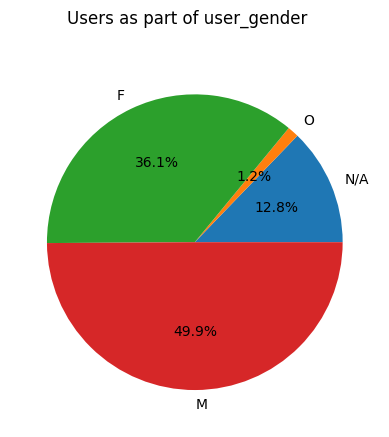

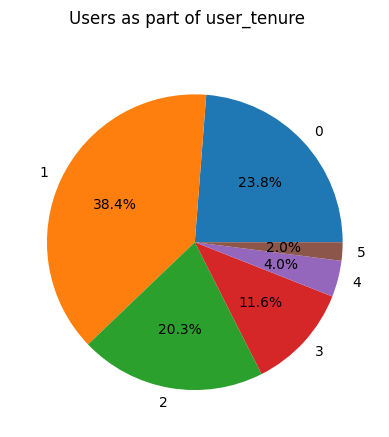

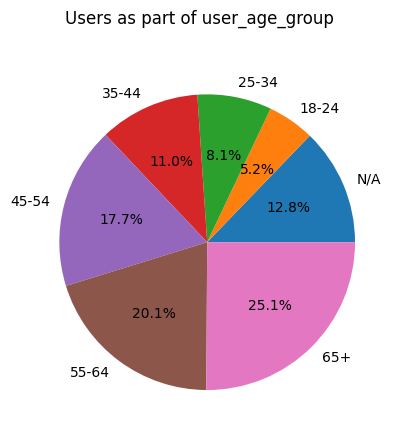

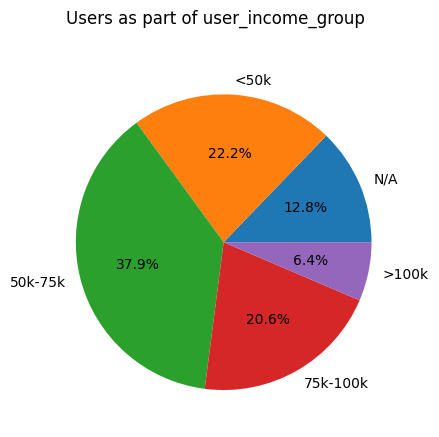

In [60]:
# https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_features.html
for cn in users.columns:
    if cn not in ['user_id', 'user_member_since', 'user_income', 'user_age']:
        agg_count = users.groupby(cn, observed=False, dropna=False).agg( count=('user_id', 'count') ).reset_index()
        # agg_count['percent'] = round( agg_count['count'] / agg_count['count'].sum() * 100, 2 )

        fig, ax = plt.subplots()
        fig.suptitle(f'Users as part of {cn}')
        ax.pie(agg_count['count'], labels=agg_count[cn], autopct='%1.1f%%' )

        plt.savefig(f"docs/images/demographics_{cn}.png")

# Interactions

In [57]:
display(interactions.head())

,user_id,offer_id,intxn_event_type,intxn_time,intxn_amount,intxn_reward
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer received,0,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer received,0,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,offer received,0,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,offer received,0,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,offer received,0,NaN,NaN


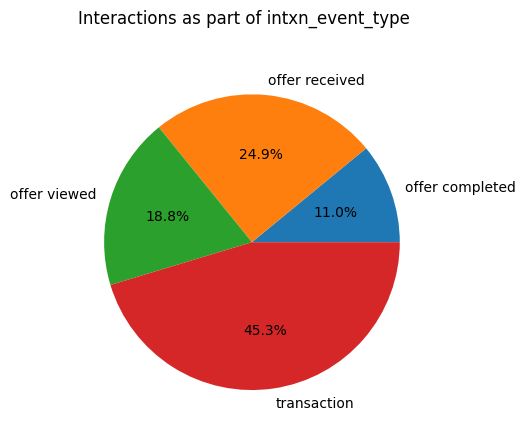

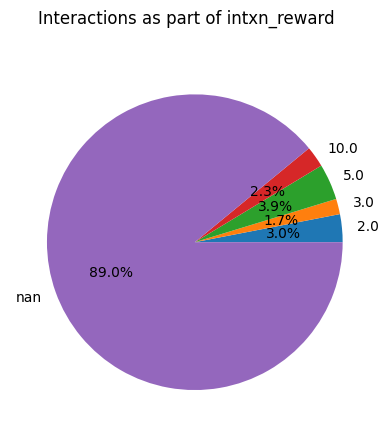

In [66]:
for cn in interactions.columns:
    if cn not in ['user_id', 'offer_id', 'intxn_time', 'intxn_amount']:
        agg_count = interactions.groupby(cn, observed=False, dropna=False).agg( count=('user_id', 'count') ).reset_index()

        fig, ax = plt.subplots()
        fig.suptitle(f'Interactions as part of {cn}')
        ax.pie(agg_count['count'], labels=agg_count[cn], autopct='%1.1f%%' )

        plt.savefig(f"docs/images/interactions_{cn}.png")

# Interactions and Users

In [73]:
intxtn_by_users = pd.merge( users, interactions, how='inner', on='user_id' )
intxtn_by_age_group = intxtn_by_users.groupby(['user_age_group', 'intxn_event_type'], observed=False).agg( count=('user_id', 'count') ).reset_index()
intxtn_by_age_group

,user_age_group,intxn_event_type,count
0,N/A,offer completed,1135
1,N/A,offer received,9776
2,N/A,offer viewed,7865
3,N/A,transaction,14996
4,18-24,offer completed,1466
5,18-24,offer received,3938
6,18-24,offer viewed,2721
7,18-24,transaction,8929
8,25-34,offer completed,2477
9,25-34,offer received,6228


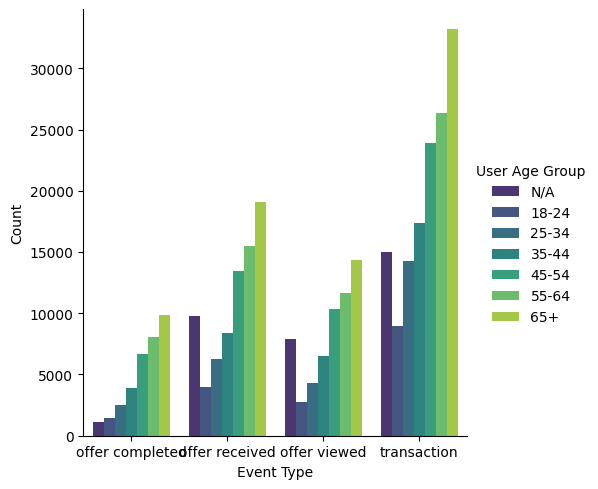

In [74]:
event_type_by_age_group_chart = sns.catplot(
    data=intxtn_by_age_group, kind='bar',
    x='intxn_event_type', y='count', 
    hue='user_age_group', 
    height=5, palette='viridis'
)

event_type_by_age_group_chart.set_axis_labels( 'Event Type', 'Count' )
sns.move_legend(event_type_by_age_group_chart, loc='center right', title='User Age Group')